## 前言
研一时接触过推荐系统的一些课本知识点，未有实地地构建一个推荐系统，当时需要完成一个大作业，我和几个同学选择了实现一个电影推荐系统，但是大框架的实现是在前人的肩膀上进行完善的，就是学习github上的项目。我负责的是前端的界面设计以及接口的实现，因此没有学习到推荐系统框架的构建核心，故重新学习推荐系统是如何构建的，对模型代码进行解析。  


[github项目入口](https://github.com/chengstone/movie_recommender)

## 电影推荐系统

### 系统模型框架
![](./pic1.jpg)

### 数据集
下载[`数据集`](http://files.grouplens.org/datasets/movielens/ml-1m.zip)

- 用户数据

In [16]:
import pandas as pd
users_title = ['UserID', 'Gender', 'Age', 'OccupationID', 'Zip-code']
users = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
# head(n),默认n=5
users.head() 

,UserID,Gender,Age,OccupationID,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


- 电影数据

In [26]:
movies_title = ['MovieID', 'Title', 'Genres']
movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
movies.head()
# for val in movies['Genres'].str.split('|'):
#     print(val)
print(len(set(movies['Title'])))

3883


- 评分数据

In [7]:
ratings_title = ['UserID', 'MovieID', 'Rating', 'timestamps']
ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
ratings.head()

,UserID,MovieID,Rating,timestamps
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


### 数据集预处理

- UserID、Occupation和MovieID不用变。
- Gender字段：需要将‘F’和‘M’转换成0和1。
- Age字段：要转成7个连续数字0~6。
- Genres字段：是分类字段，要转成数字。首先将Genres中的类别转成字符串到数字的字典，然后再将每个电影的Genres字段转成数字列表，因为有些电影是多个Genres的组合。
- Title字段：处理方式跟Genres字段一样，首先创建文本到数字的字典，然后将Title中的描述转成数字的列表。另外Title中的年份也需要去掉。
- Genres和Title字段需要将长度统一，这样在神经网络中方便处理。空白部分用‘< PAD >’对应的数字填充。

- 处理users数据
   - pd.read_table()读取数据
   - 处理Gender字段
      - users.filter(regex='xxx')过滤未用到的zip-code
      - users['Gender'].map(dict)将原始数据转换成数字进行处理
   - 处理Age字段
      - set(users['Age'])获取无序不重复的列表，得到数据集中所有不同的Age值
      - 遍历enumerate(set())获取下标以及数据本身，并创建对应数字字典(数据:下标)。此处并非是按照年龄大小排序，只需要一个一一对应即可
      - users['Age'].map(dict)将原始数据转换成数字进行处理
- 处理movies数据
   - 处理Genres字段(one-hot编码)
      - movies['Genres'].str.split('|')将原始数据转换成列表形式
      - set.update()将两个集合合并成一个集合，并无序不重复。此处遍历所有列表，并合并成一个不重复的集合，得到所有不同的Genres的一个集合
      - set.add('$<PAD>$')在Genres类型集合中添加空白类型
      - 遍历enumerate(set)，创建数字字典，获取18种电影类型以及空白类型以及对应数字的字典。
      - 通过已求得的类型字典，创建原始Genres字段数据的列表数据对应数字列表的字典
      - 遍历列表字典，并将不满足长度18的类型数字列表，已空白类型对应数字补全长度。此处max(genres2int.values())=18，调用.insert(loc,value)插入
   - 处理Title字段(one-hot编码)
      - 过滤年份，使用正则表达式re.compile()，match匹配，group提取
      - 遍历原始数据，通过set.update()获取所有title中不同的单词，并将空白单词添加进集合中
      - 遍历enumerate(set)，创建数字title字典
      - 通过数字title字典，将原始title数据转换成数字列表，并补全不足长度的数字列表
- 划分数据
   - 合并三个表，并划分出特征表和目标表
      - 合并表，pd.merge()
      - 划分表，pd.DataFrame.drop()

In [3]:
import os
import pickle
import re
def load_data():
    """
    Load Dataset from File
    """
    #读取User数据
    users_title = ['UserID', 'Gender', 'Age', 'JobID', 'Zip-code']
    users = pd.read_table('./ml-1m/users.dat', sep='::', header=None, names=users_title, engine = 'python')
    users = users.filter(regex='UserID|Gender|Age|JobID')
    users_orig = users.values
    #改变User数据中性别和年龄
    gender_map = {'F':0, 'M':1}
    users['Gender'] = users['Gender'].map(gender_map)

    age_map = {val:ii for ii,val in enumerate(set(users['Age']))}  ## set 无序不重复列表；enumerate()返回下标和数据本身。此处不需要按年龄大小排序
    users['Age'] = users['Age'].map(age_map)

    #读取Movie数据集
    movies_title = ['MovieID', 'Title', 'Genres']
    movies = pd.read_table('./ml-1m/movies.dat', sep='::', header=None, names=movies_title, engine = 'python')
    movies_orig = movies.values
    #将Title中的年份去掉
    pattern = re.compile(r'^(.*)\((\d+)\)$') 

    title_map = {val:pattern.match(val).group(1) for ii,val in enumerate(set(movies['Title']))} # match匹配，group提取
    movies['Title'] = movies['Title'].map(title_map)

    #电影类型转数字字典
    genres_set = set()
    for val in movies['Genres'].str.split('|'):
        genres_set.update(val)

    genres_set.add('<PAD>') # 将空类型添加进去
    genres2int = {val:ii for ii, val in enumerate(genres_set)}  # 每个电影类型通过enumerate转成下标对应电影类型的数字字典

    #将电影类型转成等长数字列表，长度是18
    # 每个电影对应的类型列表
    genres_map = {val:[genres2int[row] for row in val.split('|')] for ii,val in enumerate(set(movies['Genres']))}

    # 电影类型总共18种
    for key in genres_map:
        for cnt in range(max(genres2int.values()) - len(genres_map[key])):  # max(genres2int.values())=18
            genres_map[key].insert(len(genres_map[key]) + cnt,genres2int['<PAD>']) # 将类型列表已空类型对应数字补全
    
    movies['Genres'] = movies['Genres'].map(genres_map)

    #电影Title转数字字典
    title_set = set()
    for val in movies['Title'].str.split():
        title_set.update(val)
    
    title_set.add('<PAD>')
    title2int = {val:ii for ii, val in enumerate(title_set)}

    #将电影Title转成等长数字列表，长度是15
    title_count = 15
    title_map = {val:[title2int[row] for row in val.split()] for ii,val in enumerate(set(movies['Title']))}
    
    for key in title_map:
        for cnt in range(title_count - len(title_map[key])):
            title_map[key].insert(len(title_map[key]) + cnt,title2int['<PAD>'])
    
    movies['Title'] = movies['Title'].map(title_map)

    #读取评分数据集
    ratings_title = ['UserID','MovieID', 'ratings', 'timestamps']
    ratings = pd.read_table('./ml-1m/ratings.dat', sep='::', header=None, names=ratings_title, engine = 'python')
    ratings = ratings.filter(regex='UserID|MovieID|ratings')

    #合并三个表
    data = pd.merge(pd.merge(ratings, users), movies)
    
    #将数据分成X和y两张表
    target_fields = ['ratings']
    features_pd, targets_pd = data.drop(target_fields, axis=1), data[target_fields]
    
    features = features_pd.values
    targets_values = targets_pd.values
    
    return title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig

#### 加载数据并保存到本地

- title_count：Title字段的长度（15）
- title_set：Title文本的集合
- genres2int：电影类型转数字的字典
- features：是输入X
- targets_values：是学习目标y
- ratings：评分数据集的Pandas对象
- users：用户数据集的Pandas对象
- movies：电影数据的Pandas对象
- data：三个数据集组合在一起的Pandas对象
- movies_orig：没有做数据处理的原始电影数据
- users_orig：没有做数据处理的原始用户数据

In [9]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = load_data()

pickle.dump((title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig), open('preprocess.p', 'wb'))

#### 预处理后的数据

In [10]:
users.head()

,UserID,Gender,Age,JobID
0,1,0,0,10
1,2,1,5,16
2,3,1,6,15
3,4,1,2,7
4,5,1,6,20


In [11]:
movies.head()

,MovieID,Title,Genres
0,1,"[4929, 2546, 523, 523, 523, 523, 523, 523, 523...","[12, 2, 4, 13, 13, 13, 13, 13, 13, 13, 13, 13,..."
1,2,"[3210, 523, 523, 523, 523, 523, 523, 523, 523,...","[3, 2, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13,..."
2,3,"[961, 1707, 2645, 523, 523, 523, 523, 523, 523...","[4, 15, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13..."
3,4,"[877, 4632, 335, 523, 523, 523, 523, 523, 523,...","[4, 9, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,..."
4,5,"[848, 3323, 4473, 4744, 1462, 2002, 523, 523, ...","[4, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13..."


In [13]:
movies.values[0]

array([1,
       [4929, 2546, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523, 523],
       [12, 2, 4, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]], dtype=object)

#### 从本地读取数据

In [5]:
title_count, title_set, genres2int, features, targets_values, ratings, users, movies, data, movies_orig, users_orig = pickle.load(open('preprocess.p', mode='rb'))

### 搭建模型前的准备

#### 辅助函数

In [6]:
def save_params(params):
    """
    Save parameters to file
    """
    pickle.dump(params, open('params.p', 'wb'))


def load_params():
    """
    Load parameters from file
    """
    return pickle.load(open('params.p', mode='rb'))

#### 编码实现

In [7]:
#嵌入矩阵的维度
embed_dim = 32
#用户ID个数
uid_max = max(features.take(0,1)) + 1 # 6040
#性别个数
gender_max = max(features.take(2,1)) + 1 # 1 + 1 = 2
#年龄类别个数
age_max = max(features.take(3,1)) + 1 # 6 + 1 = 7
#职业个数
job_max = max(features.take(4,1)) + 1# 20 + 1 = 21

#电影ID个数
movie_id_max = max(features.take(1,1)) + 1 # 3952
#电影类型个数
movie_categories_max = max(genres2int.values()) + 1 # 18 + 1 = 19
#电影名单词个数
movie_title_max = len(title_set) # 5216

#对电影类型嵌入向量做加和操作的标志，考虑过使用mean做平均，但是没实现mean
combiner = "sum"

#电影名长度
sentences_size = title_count # = 15
#文本卷积滑动窗口，分别滑动2, 3, 4, 5个单词
window_sizes = {2, 3, 4, 5}
#文本卷积核数量
filter_num = 8

#电影ID转下标的字典，数据集中电影ID跟下标不一致，比如第5行的数据电影ID不一定是5
movieid2idx = {val[0]:i for i, val in enumerate(movies.values)}

#### 超参

In [8]:
# Number of Epochs
num_epochs = 5
# Batch Size
batch_size = 256

dropout_keep = 0.5
# Learning Rate
learning_rate = 0.0001
# Show stats for every n number of batches
show_every_n_batches = 20

save_dir = './save'

#### 输入

网络模型输入的占位符：
  - user_id: [None, 1]
  - user_gender: [None, 1]
  - user_age: [None, 1]
  - user_job: [None, 1]
  - movie_id: [None, 1]
  - movie_categories: [None, 18]
  - movie_title: [None, 15]
  - target: [None, 1]
  - learningRate
  - dropout_keep_prob

In [9]:
def get_inputs():
    uid = tf.placeholder(tf.int32, [None, 1], name="uid")
    user_gender = tf.placeholder(tf.int32, [None, 1], name="user_gender")
    user_age = tf.placeholder(tf.int32, [None, 1], name="user_age")
    user_job = tf.placeholder(tf.int32, [None, 1], name="user_job")
    
    movie_id = tf.placeholder(tf.int32, [None, 1], name="movie_id")
    movie_categories = tf.placeholder(tf.int32, [None, 18], name="movie_categories")
    movie_titles = tf.placeholder(tf.int32, [None, 15], name="movie_titles")
    targets = tf.placeholder(tf.int32, [None, 1], name="targets")
    LearningRate = tf.placeholder(tf.float32, name = "LearningRate")
    dropout_keep_prob = tf.placeholder(tf.float32, name = "dropout_keep_prob")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, LearningRate, dropout_keep_prob

### 嵌入层设计
将数据转换成词向量，使得词与词产生的向量之间存在某种联系

#### 介绍tensorflow中的embedding_lookup()

> tf.nn.embedding_lookup(params, ids, partition_strategy='mod', name=None, validate_indices=True, max_norm=None)

In [10]:
import numpy as np
import tensorflow as tf

sess = tf.InteractiveSession()

# embedding = tf.Variable(tf.random_uniform([50, 16], -1, 1))
embedding = tf.Variable(np.identity(6, dtype=np.int32))
input_ids = tf.placeholder(dtype=tf.int32, shape=[None])
input_embedding = tf.nn.embedding_lookup(embedding, input_ids)

sess.run(tf.global_variables_initializer())
print(sess.run(embedding))
print(sess.run(input_embedding, feed_dict={input_ids: [4, 0, 2, 4, 5, 1, 3, 0]}))

[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]
[[0 0 0 0 1 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]
 [0 1 0 0 0 0]
 [0 0 0 1 0 0]
 [1 0 0 0 0 0]]


input_embedding = tf.nn.embedding_lookup(embedding, input_ids)返回的是embedding矩阵中第input_ids行的列表。  

从以上简单示例可以看出，embedding将变量表现成了one-hot形式，而input_embedding = tf.nn.embedding_lookup(embedding, input_ids)就是把input_ids中给出的tensor表现成embedding中的形式。

简单来说第一个矩阵是创建了一个embedding词典，第二个矩阵是通过输入的input_ids查询上部的字典得到embedding后的值。而字典是可以由用户随意创建的，上面给出的是一个one-hot字典，还可以自由创建其他字典，例如使用正态分布或均匀分布产生（0，1）的随机数创建任意维度的embedding字典

也就是说 embedding_lookup是tensorflow中给出的用于以某种方式进行embedding的函数

#### 定义users的嵌入矩阵
通过研究数据集中的字段类型，我们发现有一些是类别字段，通常的处理是将这些字段转成one hot编码，但是像UserID、MovieID这样的字段就会变成非常的稀疏，输入的维度急剧膨胀，这是我们不愿意见到的。  
所以在预处理数据时将这些字段转成了数字，我们用这个数字当做嵌入矩阵的索引，在网络的第一层使用了嵌入层，维度是（N，32）和（N，16）。

- uid的词向量转换：创建embedding词典[uid_max, embed_dim]=[6040, 32],通过embedding_lookup得到embedding后的嵌入矩阵[6040, 32]
- Genres的词向量转换：...
- age的词向量转换：...
- job的词向量转换：...

In [11]:
def get_user_embedding(uid, user_gender, user_age, user_job):
    with tf.name_scope("user_embedding"):
        uid_embed_matrix = tf.Variable(tf.random_uniform([uid_max, embed_dim], -1, 1), name = "uid_embed_matrix")
        uid_embed_layer = tf.nn.embedding_lookup(uid_embed_matrix, uid, name = "uid_embed_layer")
    
        gender_embed_matrix = tf.Variable(tf.random_uniform([gender_max, embed_dim // 2], -1, 1), name= "gender_embed_matrix")
        gender_embed_layer = tf.nn.embedding_lookup(gender_embed_matrix, user_gender, name = "gender_embed_layer")
        
        age_embed_matrix = tf.Variable(tf.random_uniform([age_max, embed_dim // 2], -1, 1), name="age_embed_matrix")
        age_embed_layer = tf.nn.embedding_lookup(age_embed_matrix, user_age, name="age_embed_layer")
        
        job_embed_matrix = tf.Variable(tf.random_uniform([job_max, embed_dim // 2], -1, 1), name = "job_embed_matrix")
        job_embed_layer = tf.nn.embedding_lookup(job_embed_matrix, user_job, name = "job_embed_layer")
    return uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer

- return: 将uid, user_gender, user_age, user_job这些数字作为索引，在对应的embedding矩阵中检索到索引行作为词向量

#### 定义Movie ID的嵌入矩阵

- Movie ID的词向量转换：...

In [12]:
def get_movie_id_embed_layer(movie_id):
    with tf.name_scope("movie_embedding"):
        movie_id_embed_matrix = tf.Variable(tf.random_uniform([movie_id_max, embed_dim], -1, 1), name = "movie_id_embed_matrix")
        movie_id_embed_layer = tf.nn.embedding_lookup(movie_id_embed_matrix, movie_id, name = "movie_id_embed_layer")
    return movie_id_embed_layer

- return: ...

#### 定义Movie Genres的嵌入矩阵

电影类型的处理要多一步，有时一个电影有多个电影类型，这样从嵌入矩阵索引出来是一个（n，32）的矩阵，因为有多个类型嘛，我们要将这个矩阵求和，变成（1，32）的向量。

In [13]:
def get_movie_categories_layers(movie_categories):
    with tf.name_scope("movie_categories_layers"):
        movie_categories_embed_matrix = tf.Variable(tf.random_uniform([movie_categories_max, embed_dim], -1, 1), name = "movie_categories_embed_matrix")
        movie_categories_embed_layer = tf.nn.embedding_lookup(movie_categories_embed_matrix, movie_categories, name = "movie_categories_embed_layer")
        if combiner == "sum":
            movie_categories_embed_layer = tf.reduce_sum(movie_categories_embed_layer, axis=1, keep_dims=True)
    #     elif combiner == "mean":

    return movie_categories_embed_layer

- return: 由于movie_categories是一个数字列表，作为索引列表，从embedding矩阵中索引得到词向量矩阵，将这些词向量加和，得到一维的词向量

### Movie title的文本卷积网络设计

- 嵌入层
  - movie_title_embed_matrix： 嵌入矩阵embedding[5216， 32]
  - movie_title_embed_layer： movie_titles的词向量矩阵[15, 32]
  - movie_title_embed_layer_expand:  增加末尾维度[16, 32]
- 卷积网络
  - 原始输入数据矩阵[16, 32]
  - 卷积核权重矩阵[window_size, embed_dim, 1, filter_num]=[window_size, 32, 1, 8]
     - [window_size, 32]权重矩阵，此处是已window_size为滑动窗口，整体往下进行卷积计算
     - 1，表示输入的特征图只有1个
     - 8，表示卷积核个数为8，同样输出的特征图为8个
  - 偏置bias: tf.constant(0.1, shape=[filter_num]
  - 卷积计算：tf.nn.conv2d(movie_title_embed_layer_expand, filter_weights, [1,1,1,1]) + bias
  - 激活函数：tf.nn.relu()
  - 池化层：tf.nn.max_pool(relu_layer, [1,sentences_size - window_size + 1 ,1,1], [1,1,1,1])
     - relu_layer：经过激活函数后的矩阵值
     - [1,sentences_size - window_size + 1 ,1,1]：以[sentences_size - window_size + 1 ,1]网格大小进行池化
     - [1,1,1,1]：池化步长为[1, 1]
  - dropout层
     - dropout layer的目的是为了防止CNN 过拟合：首先，想象我们现在只训练一个特定的网络，当迭代次数增多的时候，可能出现网络对训练集拟合的很好（在训练集上loss很小），但是对验证集的拟合程度很差的情况。所以，我们有了这样的想法：可不可以让每次跌代随机的去更新网络参数（weights），引入这样的随机性就可以增加网络generalize 的能力。所以就有了dropout 。在训练的时候，我们只需要按一定的概率（retaining probability）p 来对weight layer 的参数进行随机采样，将这个子网络作为此次更新的目标网络。可以想象，如果整个网络有n个参数，那么我们可用的子网络个数为 2^n 。 并且，当n很大时，每次迭代更新 使用的子网络基本上不会重复，从而避免了某一个网络被过分的拟合到训练集上。
     - 经过卷积池化后的矩阵shape为(8, -, -)，因此不同尺寸卷积核构造的pool_layer_lst的shape为(len(window_sizes), 8, -, -)
     - tf.concat(pool_layer_lst, 3)表示在第4维度上连接pool_layer_lst矩阵


In [14]:
def get_movie_cnn_layer(movie_titles):
    #从嵌入矩阵中得到电影名对应的各个单词的嵌入向量
    with tf.name_scope("movie_embedding"):
        movie_title_embed_matrix = tf.Variable(tf.random_uniform([movie_title_max, embed_dim], -1, 1), name = "movie_title_embed_matrix")
        movie_title_embed_layer = tf.nn.embedding_lookup(movie_title_embed_matrix, movie_titles, name = "movie_title_embed_layer")
        movie_title_embed_layer_expand = tf.expand_dims(movie_title_embed_layer, -1)
    
    #对文本嵌入层使用不同尺寸的卷积核做卷积和最大池化
    pool_layer_lst = []
    for window_size in window_sizes:
        with tf.name_scope("movie_txt_conv_maxpool_{}".format(window_size)):
            filter_weights = tf.Variable(tf.truncated_normal([window_size, embed_dim, 1, filter_num],stddev=0.1),name = "filter_weights")
            filter_bias = tf.Variable(tf.constant(0.1, shape=[filter_num]), name="filter_bias")
            
            conv_layer = tf.nn.conv2d(movie_title_embed_layer_expand, filter_weights, [1,1,1,1], padding="VALID", name="conv_layer")
            relu_layer = tf.nn.relu(tf.nn.bias_add(conv_layer,filter_bias), name ="relu_layer")
            
            maxpool_layer = tf.nn.max_pool(relu_layer, [1,sentences_size - window_size + 1 ,1,1], [1,1,1,1], padding="VALID", name="maxpool_layer")
            pool_layer_lst.append(maxpool_layer)

    #Dropout层
    with tf.name_scope("pool_dropout"):
        pool_layer = tf.concat(pool_layer_lst, 3, name ="pool_layer")
        max_num = len(window_sizes) * filter_num
        pool_layer_flat = tf.reshape(pool_layer , [-1, 1, max_num], name = "pool_layer_flat")
    
        dropout_layer = tf.nn.dropout(pool_layer_flat, dropout_keep_prob, name = "dropout_layer")
    return pool_layer_flat, dropout_layer

#### 介绍tf.concat()与tf.reshape()
##### tf.concat([tensor1, tensor2, tensor3,...], axis)

In [41]:
t1 = [[[1, 2], [2, 3]], [[4, 4], [5, 3]]]
t2 = [[[7, 4], [8, 4]], [[2, 10], [15, 11]]]
tf.concat([t1, t2], axis=-1)

<tf.Tensor 'concat_5:0' shape=(2, 2, 4) dtype=int32>

对于t1多维矩阵，其shape为(2, 2, 2)(判断括号的组成)。一个多维矩阵，第axis=0个维度代表最外层方括号所框下的子集，第i个维度代表内部第i个方括号所框下的子集。维度越高，括号越小。

对于这种情况，我可以再解释清楚一点: 

对于[[ ], [ ]]和[[ ], [ ]]，低维拼接等于拿掉最外面括号，高维拼接是拿掉里面的括号(保证其他维度不变)。注意：tf.concat()拼接的张量只会改变一个维度，其他维度是保存不变的。比如两个shape为[2,3]的矩阵拼接，要么通过axis=0变成[4,3]，要么通过axis=1变成[2,6]。改变的维度索引对应axis的值。

如上面例子，axis为-1，即为最内部维度，其shape变成(2, 2, 4)，将最内部的括号去掉拼接，得到[[[1, 2, 7, 4], [2, 3, 8, 4]], [[4, 4, 2, 10], [5, 3, 15, 11]]]


##### tf.shape()
![](./pic2.png)

### 全连接层设计
通过一个或者多个全连接层，对数据特征进行训练，最终得到用户特征和电影特征

#### user全连接设计
- tf.layers.dense(inputs, units, activation)：输入数据、输出维度、激活函数--全连接层
   - uid_embed_layer等的shape为(1, -)，全连接层输出shape为(-, 32)
   - user_combine_layer的shape为(1, 32*4)=(1, 128)
   - 经过第二层全连接，user_combine_layer的shape为(1，200)
- tf.concat()：将多个词向量拼接一起
- tf.contrib.layers.fully_connected()--全连接层

In [15]:
def get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer):
    with tf.name_scope("user_fc"):
        #第一层全连接
        uid_fc_layer = tf.layers.dense(uid_embed_layer, embed_dim, name = "uid_fc_layer", activation=tf.nn.relu)
        gender_fc_layer = tf.layers.dense(gender_embed_layer, embed_dim, name = "gender_fc_layer", activation=tf.nn.relu)
        age_fc_layer = tf.layers.dense(age_embed_layer, embed_dim, name ="age_fc_layer", activation=tf.nn.relu)
        job_fc_layer = tf.layers.dense(job_embed_layer, embed_dim, name = "job_fc_layer", activation=tf.nn.relu)
        
        #第二层全连接
        user_combine_layer = tf.concat([uid_fc_layer, gender_fc_layer, age_fc_layer, job_fc_layer], 2)  #(?, 1, 128)
        user_combine_layer = tf.contrib.layers.fully_connected(user_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        user_combine_layer_flat = tf.reshape(user_combine_layer, [-1, 200])
    return user_combine_layer, user_combine_layer_flat

#### movie全连接设计

In [16]:
def get_movie_feature_layer(movie_id_embed_layer, movie_categories_embed_layer, dropout_layer):
    with tf.name_scope("movie_fc"):
        #第一层全连接
        movie_id_fc_layer = tf.layers.dense(movie_id_embed_layer, embed_dim, name = "movie_id_fc_layer", activation=tf.nn.relu)
        movie_categories_fc_layer = tf.layers.dense(movie_categories_embed_layer, embed_dim, name = "movie_categories_fc_layer", activation=tf.nn.relu)
    
        #第二层全连接
        movie_combine_layer = tf.concat([movie_id_fc_layer, movie_categories_fc_layer, dropout_layer], 2)  #(?, 1, 96)
        movie_combine_layer = tf.contrib.layers.fully_connected(movie_combine_layer, 200, tf.tanh)  #(?, 1, 200)
    
        movie_combine_layer_flat = tf.reshape(movie_combine_layer, [-1, 200])
    return movie_combine_layer, movie_combine_layer_flat

### 构建计算图-拟合特征设计
将用户特征与电影特征进行拟合评分，得到预测评分

In [17]:
tf.reset_default_graph()
train_graph = tf.Graph()
with train_graph.as_default():
    #获取输入占位符
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob = get_inputs()
    #获取User的4个嵌入向量
    uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer = get_user_embedding(uid, user_gender, user_age, user_job)
    #得到用户特征
    user_combine_layer, user_combine_layer_flat = get_user_feature_layer(uid_embed_layer, gender_embed_layer, age_embed_layer, job_embed_layer)
    #获取电影ID的嵌入向量
    movie_id_embed_layer = get_movie_id_embed_layer(movie_id)
    #获取电影类型的嵌入向量
    movie_categories_embed_layer = get_movie_categories_layers(movie_categories)
    #获取电影名的特征向量
    pool_layer_flat, dropout_layer = get_movie_cnn_layer(movie_titles)
    #得到电影特征
    movie_combine_layer, movie_combine_layer_flat = get_movie_feature_layer(movie_id_embed_layer, 
                                                                                movie_categories_embed_layer, 
                                                                                dropout_layer)
    #计算出评分，要注意两个不同的方案，inference的名字（name值）是不一样的，后面做推荐时要根据name取得tensor
    with tf.name_scope("inference"):
        #将用户特征和电影特征作为输入，经过全连接，输出一个值的方案
#         inference_layer = tf.concat([user_combine_layer_flat, movie_combine_layer_flat], 1)  #(?, 200)
#         inference = tf.layers.dense(inference_layer, 1,
#                                     kernel_initializer=tf.truncated_normal_initializer(stddev=0.01), 
#                                     kernel_regularizer=tf.nn.l2_loss, name="inference")
        #简单的将用户特征和电影特征做矩阵乘法得到一个预测评分
#        inference = tf.matmul(user_combine_layer_flat, tf.transpose(movie_combine_layer_flat))
        inference = tf.reduce_sum(user_combine_layer_flat * movie_combine_layer_flat, axis=1)
        inference = tf.expand_dims(inference, axis=1)

    with tf.name_scope("loss"):
        # MSE损失，将计算值回归到评分
        cost = tf.losses.mean_squared_error(targets, inference )
        loss = tf.reduce_mean(cost)
    # 优化损失 
#     train_op = tf.train.AdamOptimizer(lr).minimize(loss)  #cost
    global_step = tf.Variable(0, name="global_step", trainable=False)
    optimizer = tf.train.AdamOptimizer(lr)
    gradients = optimizer.compute_gradients(loss)  #cost
    train_op = optimizer.apply_gradients(gradients, global_step=global_step)

In [18]:
inference

<tf.Tensor 'inference/ExpandDims:0' shape=(?, 1) dtype=float32>

### 训练网络

In [20]:
def get_batches(Xs, ys, batch_size):
    for start in range(0, len(Xs), batch_size):
        end = min(start + batch_size, len(Xs))
        yield Xs[start:end], ys[start:end]
        
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
import datetime

losses = {'train':[], 'test':[]}

with tf.Session(graph=train_graph) as sess:
    
    #搜集数据给tensorBoard用
    # Keep track of gradient values and sparsity
    grad_summaries = []
    for g, v in gradients:
        if g is not None:
            grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name.replace(':', '_')), g)
            sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name.replace(':', '_')), tf.nn.zero_fraction(g))
            grad_summaries.append(grad_hist_summary)
            grad_summaries.append(sparsity_summary)
    grad_summaries_merged = tf.summary.merge(grad_summaries)
        
    # Output directory for models and summaries
    timestamp = str(int(time.time()))
    out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp))
    print("Writing to {}\n".format(out_dir))
     
    # Summaries for loss and accuracy
    loss_summary = tf.summary.scalar("loss", loss)

    # Train Summaries
    train_summary_op = tf.summary.merge([loss_summary, grad_summaries_merged])
    train_summary_dir = os.path.join(out_dir, "summaries", "train")
    train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

    # Inference summaries
    inference_summary_op = tf.summary.merge([loss_summary])
    inference_summary_dir = os.path.join(out_dir, "summaries", "inference")
    inference_summary_writer = tf.summary.FileWriter(inference_summary_dir, sess.graph)

    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for epoch_i in range(num_epochs):
        
        #将数据集分成训练集和测试集，随机种子不固定
        train_X,test_X, train_y, test_y = train_test_split(features,  
                                                           targets_values,  
                                                           test_size = 0.2,  
                                                           random_state = 0)  
        
        train_batches = get_batches(train_X, train_y, batch_size)
        test_batches = get_batches(test_X, test_y, batch_size)
    
        #训练的迭代，保存训练损失
        for batch_i in range(len(train_X) // batch_size):
            x, y = next(train_batches)

            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: dropout_keep, #dropout_keep
                lr: learning_rate}

            step, train_loss, summaries, _ = sess.run([global_step, loss, train_summary_op, train_op], feed)  #cost
            losses['train'].append(train_loss)
            train_summary_writer.add_summary(summaries, step)  #
            
            # Show every <show_every_n_batches> batches
            if (epoch_i * (len(train_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                time_str = datetime.datetime.now().isoformat()
                print('{}: Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(train_X) // batch_size),
                    train_loss))
                
        #使用测试数据的迭代
        for batch_i  in range(len(test_X) // batch_size):
            x, y = next(test_batches)
            
            categories = np.zeros([batch_size, 18])
            for i in range(batch_size):
                categories[i] = x.take(6,1)[i]

            titles = np.zeros([batch_size, sentences_size])
            for i in range(batch_size):
                titles[i] = x.take(5,1)[i]

            feed = {
                uid: np.reshape(x.take(0,1), [batch_size, 1]),
                user_gender: np.reshape(x.take(2,1), [batch_size, 1]),
                user_age: np.reshape(x.take(3,1), [batch_size, 1]),
                user_job: np.reshape(x.take(4,1), [batch_size, 1]),
                movie_id: np.reshape(x.take(1,1), [batch_size, 1]),
                movie_categories: categories,  #x.take(6,1)
                movie_titles: titles,  #x.take(5,1)
                targets: np.reshape(y, [batch_size, 1]),
                dropout_keep_prob: 1,
                lr: learning_rate}
            
            step, test_loss, summaries = sess.run([global_step, loss, inference_summary_op], feed)  #cost

            #保存测试损失
            losses['test'].append(test_loss)
            inference_summary_writer.add_summary(summaries, step)  #

            time_str = datetime.datetime.now().isoformat()
            if (epoch_i * (len(test_X) // batch_size) + batch_i) % show_every_n_batches == 0:
                print('{}: Epoch {:>3} Batch {:>4}/{}   test_loss = {:.3f}'.format(
                    time_str,
                    epoch_i,
                    batch_i,
                    (len(test_X) // batch_size),
                    test_loss))

    # Save Model
    saver.save(sess, save_dir)  #, global_step=epoch_i
    print('Model Trained and Saved')

Writing to C:\Users\Tiny\Desktop\推荐系统\runs\1551329730

2019-02-28T12:55:41.227300: Epoch   0 Batch    0/3125   train_loss = 17.314
2019-02-28T12:55:42.847652: Epoch   0 Batch   20/3125   train_loss = 5.116
2019-02-28T12:55:44.590507: Epoch   0 Batch   40/3125   train_loss = 3.131
2019-02-28T12:55:46.243630: Epoch   0 Batch   60/3125   train_loss = 2.430
2019-02-28T12:55:48.288286: Epoch   0 Batch   80/3125   train_loss = 2.147
2019-02-28T12:55:49.975660: Epoch   0 Batch  100/3125   train_loss = 2.013
2019-02-28T12:55:52.231178: Epoch   0 Batch  120/3125   train_loss = 1.807
2019-02-28T12:55:54.042987: Epoch   0 Batch  140/3125   train_loss = 1.785
2019-02-28T12:55:55.908550: Epoch   0 Batch  160/3125   train_loss = 1.348
2019-02-28T12:55:57.706369: Epoch   0 Batch  180/3125   train_loss = 1.512
2019-02-28T12:55:59.378085: Epoch   0 Batch  200/3125   train_loss = 1.567
2019-02-28T12:56:01.074353: Epoch   0 Batch  220/3125   train_loss = 1.518
2019-02-28T12:56:02.859181: Epoch   0 Batch 

2019-02-28T12:58:42.589871: Epoch   0 Batch 2180/3125   train_loss = 1.153
2019-02-28T12:58:44.188093: Epoch   0 Batch 2200/3125   train_loss = 1.074
2019-02-28T12:58:45.731345: Epoch   0 Batch 2220/3125   train_loss = 1.091
2019-02-28T12:58:47.384258: Epoch   0 Batch 2240/3125   train_loss = 1.015
2019-02-28T12:58:49.065719: Epoch   0 Batch 2260/3125   train_loss = 1.187
2019-02-28T12:58:50.757449: Epoch   0 Batch 2280/3125   train_loss = 1.147
2019-02-28T12:58:52.336737: Epoch   0 Batch 2300/3125   train_loss = 1.167
2019-02-28T12:58:53.938684: Epoch   0 Batch 2320/3125   train_loss = 1.277
2019-02-28T12:58:55.575077: Epoch   0 Batch 2340/3125   train_loss = 1.153
2019-02-28T12:58:57.132306: Epoch   0 Batch 2360/3125   train_loss = 1.173
2019-02-28T12:58:58.771197: Epoch   0 Batch 2380/3125   train_loss = 1.101
2019-02-28T12:59:00.370836: Epoch   0 Batch 2400/3125   train_loss = 1.277
2019-02-28T12:59:01.913980: Epoch   0 Batch 2420/3125   train_loss = 1.127
2019-02-28T12:59:03.59106

2019-02-28T13:00:48.085694: Epoch   1 Batch  475/3125   train_loss = 1.083
2019-02-28T13:00:49.775584: Epoch   1 Batch  495/3125   train_loss = 1.093
2019-02-28T13:00:51.395245: Epoch   1 Batch  515/3125   train_loss = 1.142
2019-02-28T13:00:52.981370: Epoch   1 Batch  535/3125   train_loss = 1.099
2019-02-28T13:00:54.538541: Epoch   1 Batch  555/3125   train_loss = 1.167
2019-02-28T13:00:56.111981: Epoch   1 Batch  575/3125   train_loss = 1.045
2019-02-28T13:00:57.721354: Epoch   1 Batch  595/3125   train_loss = 1.261
2019-02-28T13:00:59.344444: Epoch   1 Batch  615/3125   train_loss = 1.045
2019-02-28T13:01:00.952329: Epoch   1 Batch  635/3125   train_loss = 1.106
2019-02-28T13:01:02.679194: Epoch   1 Batch  655/3125   train_loss = 0.939
2019-02-28T13:01:04.320648: Epoch   1 Batch  675/3125   train_loss = 0.905
2019-02-28T13:01:05.877625: Epoch   1 Batch  695/3125   train_loss = 1.056
2019-02-28T13:01:07.473927: Epoch   1 Batch  715/3125   train_loss = 1.109
2019-02-28T13:01:09.06276

2019-02-28T13:03:45.709444: Epoch   1 Batch 2675/3125   train_loss = 1.029
2019-02-28T13:03:47.281411: Epoch   1 Batch 2695/3125   train_loss = 0.992
2019-02-28T13:03:48.855379: Epoch   1 Batch 2715/3125   train_loss = 0.991
2019-02-28T13:03:50.461486: Epoch   1 Batch 2735/3125   train_loss = 0.829
2019-02-28T13:03:52.034174: Epoch   1 Batch 2755/3125   train_loss = 1.038
2019-02-28T13:03:53.651112: Epoch   1 Batch 2775/3125   train_loss = 1.134
2019-02-28T13:03:55.249497: Epoch   1 Batch 2795/3125   train_loss = 0.996
2019-02-28T13:03:56.826680: Epoch   1 Batch 2815/3125   train_loss = 0.945
2019-02-28T13:03:58.450263: Epoch   1 Batch 2835/3125   train_loss = 1.027
2019-02-28T13:04:00.068001: Epoch   1 Batch 2855/3125   train_loss = 1.098
2019-02-28T13:04:01.657402: Epoch   1 Batch 2875/3125   train_loss = 1.043
2019-02-28T13:04:03.235896: Epoch   1 Batch 2895/3125   train_loss = 1.075
2019-02-28T13:04:04.899257: Epoch   1 Batch 2915/3125   train_loss = 0.953
2019-02-28T13:04:06.49436

2019-02-28T13:05:53.496855: Epoch   2 Batch  990/3125   train_loss = 0.854
2019-02-28T13:05:55.083469: Epoch   2 Batch 1010/3125   train_loss = 1.174
2019-02-28T13:05:56.679455: Epoch   2 Batch 1030/3125   train_loss = 0.932
2019-02-28T13:05:58.323895: Epoch   2 Batch 1050/3125   train_loss = 0.900
2019-02-28T13:05:59.973060: Epoch   2 Batch 1070/3125   train_loss = 0.930
2019-02-28T13:06:01.547406: Epoch   2 Batch 1090/3125   train_loss = 1.093
2019-02-28T13:06:03.149515: Epoch   2 Batch 1110/3125   train_loss = 1.049
2019-02-28T13:06:04.736774: Epoch   2 Batch 1130/3125   train_loss = 0.956
2019-02-28T13:06:06.426831: Epoch   2 Batch 1150/3125   train_loss = 0.955
2019-02-28T13:06:08.027942: Epoch   2 Batch 1170/3125   train_loss = 0.959
2019-02-28T13:06:09.712635: Epoch   2 Batch 1190/3125   train_loss = 1.025
2019-02-28T13:06:11.320738: Epoch   2 Batch 1210/3125   train_loss = 0.856
2019-02-28T13:06:12.923652: Epoch   2 Batch 1230/3125   train_loss = 0.870
2019-02-28T13:06:14.53059

2019-02-28T13:08:50.670768: Epoch   2 Batch   78/781   test_loss = 0.911
2019-02-28T13:08:50.939592: Epoch   2 Batch   98/781   test_loss = 0.961
2019-02-28T13:08:51.204458: Epoch   2 Batch  118/781   test_loss = 0.862
2019-02-28T13:08:51.468285: Epoch   2 Batch  138/781   test_loss = 1.008
2019-02-28T13:08:51.752567: Epoch   2 Batch  158/781   test_loss = 0.815
2019-02-28T13:08:52.014395: Epoch   2 Batch  178/781   test_loss = 0.836
2019-02-28T13:08:52.273225: Epoch   2 Batch  198/781   test_loss = 0.938
2019-02-28T13:08:52.536052: Epoch   2 Batch  218/781   test_loss = 1.014
2019-02-28T13:08:52.801878: Epoch   2 Batch  238/781   test_loss = 0.996
2019-02-28T13:08:53.067703: Epoch   2 Batch  258/781   test_loss = 1.013
2019-02-28T13:08:53.328531: Epoch   2 Batch  278/781   test_loss = 1.033
2019-02-28T13:08:53.594357: Epoch   2 Batch  298/781   test_loss = 0.894
2019-02-28T13:08:53.853892: Epoch   2 Batch  318/781   test_loss = 0.883
2019-02-28T13:08:54.115376: Epoch   2 Batch  338/78

2019-02-28T13:11:16.521134: Epoch   3 Batch 1505/3125   train_loss = 0.769
2019-02-28T13:11:18.459860: Epoch   3 Batch 1525/3125   train_loss = 0.792
2019-02-28T13:11:20.420572: Epoch   3 Batch 1545/3125   train_loss = 0.917
2019-02-28T13:11:22.063782: Epoch   3 Batch 1565/3125   train_loss = 0.854
2019-02-28T13:11:23.621759: Epoch   3 Batch 1585/3125   train_loss = 0.871
2019-02-28T13:11:25.228192: Epoch   3 Batch 1605/3125   train_loss = 0.999
2019-02-28T13:11:26.836896: Epoch   3 Batch 1625/3125   train_loss = 0.972
2019-02-28T13:11:28.468220: Epoch   3 Batch 1645/3125   train_loss = 0.971
2019-02-28T13:11:30.072209: Epoch   3 Batch 1665/3125   train_loss = 0.940
2019-02-28T13:11:31.670800: Epoch   3 Batch 1685/3125   train_loss = 0.987
2019-02-28T13:11:33.331877: Epoch   3 Batch 1705/3125   train_loss = 0.955
2019-02-28T13:11:34.893012: Epoch   3 Batch 1725/3125   train_loss = 0.829
2019-02-28T13:11:36.451156: Epoch   3 Batch 1745/3125   train_loss = 0.783
2019-02-28T13:11:38.06275

2019-02-28T13:13:39.458646: Epoch   3 Batch  617/781   test_loss = 0.854
2019-02-28T13:13:39.718361: Epoch   3 Batch  637/781   test_loss = 0.799
2019-02-28T13:13:39.995401: Epoch   3 Batch  657/781   test_loss = 1.054
2019-02-28T13:13:40.326183: Epoch   3 Batch  677/781   test_loss = 0.914
2019-02-28T13:13:40.586013: Epoch   3 Batch  697/781   test_loss = 0.948
2019-02-28T13:13:40.852838: Epoch   3 Batch  717/781   test_loss = 0.875
2019-02-28T13:13:41.117664: Epoch   3 Batch  737/781   test_loss = 0.757
2019-02-28T13:13:41.389485: Epoch   3 Batch  757/781   test_loss = 1.097
2019-02-28T13:13:41.652312: Epoch   3 Batch  777/781   test_loss = 0.906
2019-02-28T13:13:42.403096: Epoch   4 Batch    0/3125   train_loss = 0.955
2019-02-28T13:13:44.638790: Epoch   4 Batch   20/3125   train_loss = 0.866
2019-02-28T13:13:46.294011: Epoch   4 Batch   40/3125   train_loss = 0.910
2019-02-28T13:13:47.964048: Epoch   4 Batch   60/3125   train_loss = 0.722
2019-02-28T13:13:49.545001: Epoch   4 Batch

2019-02-28T13:16:30.217070: Epoch   4 Batch 2020/3125   train_loss = 0.984
2019-02-28T13:16:31.807202: Epoch   4 Batch 2040/3125   train_loss = 0.801
2019-02-28T13:16:33.405338: Epoch   4 Batch 2060/3125   train_loss = 0.831
2019-02-28T13:16:34.988681: Epoch   4 Batch 2080/3125   train_loss = 1.016
2019-02-28T13:16:36.590951: Epoch   4 Batch 2100/3125   train_loss = 0.822
2019-02-28T13:16:38.198895: Epoch   4 Batch 2120/3125   train_loss = 0.823
2019-02-28T13:16:40.015086: Epoch   4 Batch 2140/3125   train_loss = 0.907
2019-02-28T13:16:41.700979: Epoch   4 Batch 2160/3125   train_loss = 0.895
2019-02-28T13:16:43.338894: Epoch   4 Batch 2180/3125   train_loss = 0.920
2019-02-28T13:16:44.937007: Epoch   4 Batch 2200/3125   train_loss = 0.855
2019-02-28T13:16:46.561430: Epoch   4 Batch 2220/3125   train_loss = 0.802
2019-02-28T13:16:48.222493: Epoch   4 Batch 2240/3125   train_loss = 0.859
2019-02-28T13:16:49.975929: Epoch   4 Batch 2260/3125   train_loss = 0.945
2019-02-28T13:16:51.64422

In [21]:
save_params((save_dir))

load_dir = load_params()

#### 显示训练loss

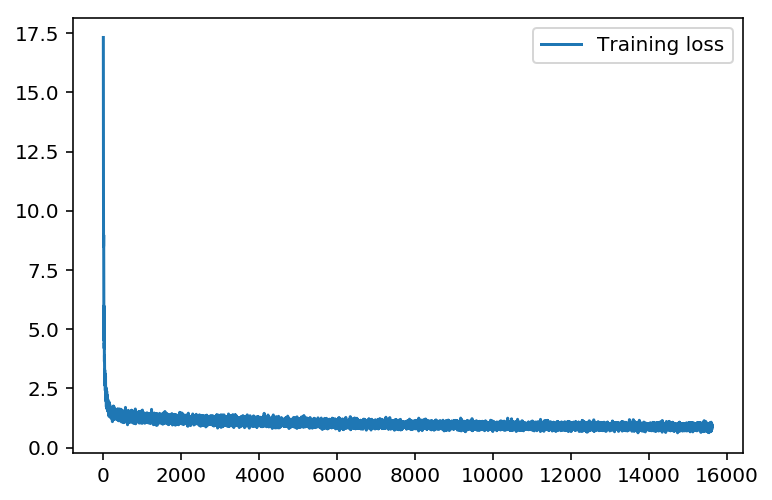

In [22]:
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

#### 显示测试loss

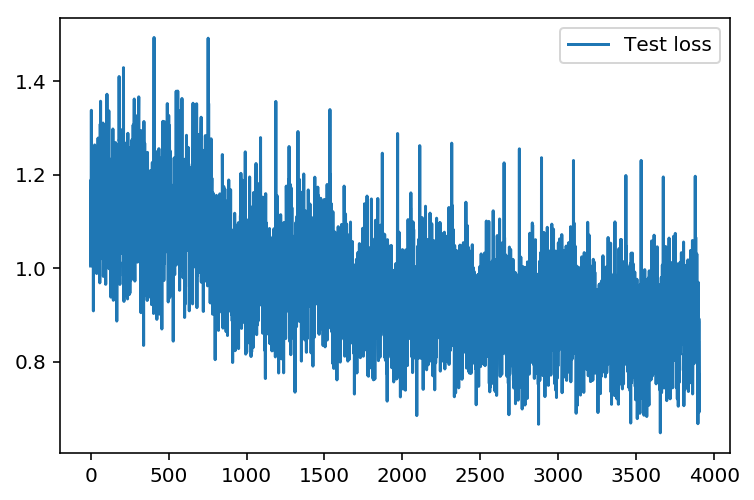

In [23]:
plt.plot(losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

#### 获取 Tensors
使用函数 [`get_tensor_by_name()`](https://www.tensorflow.org/api_docs/python/tf/Graph#get_tensor_by_name)从 `loaded_graph` 中获取tensors，后面的推荐功能要用到。

In [24]:
def get_tensors(loaded_graph):

    uid = loaded_graph.get_tensor_by_name("uid:0")
    user_gender = loaded_graph.get_tensor_by_name("user_gender:0")
    user_age = loaded_graph.get_tensor_by_name("user_age:0")
    user_job = loaded_graph.get_tensor_by_name("user_job:0")
    movie_id = loaded_graph.get_tensor_by_name("movie_id:0")
    movie_categories = loaded_graph.get_tensor_by_name("movie_categories:0")
    movie_titles = loaded_graph.get_tensor_by_name("movie_titles:0")
    targets = loaded_graph.get_tensor_by_name("targets:0")
    dropout_keep_prob = loaded_graph.get_tensor_by_name("dropout_keep_prob:0")
    lr = loaded_graph.get_tensor_by_name("LearningRate:0")
    #两种不同计算预测评分的方案使用不同的name获取tensor inference
#     inference = loaded_graph.get_tensor_by_name("inference/inference/BiasAdd:0")
    inference = loaded_graph.get_tensor_by_name("inference/ExpandDims:0") # 之前是MatMul:0 因为inference代码修改了 这里也要修改 感谢网友 @清歌 指出问题
    movie_combine_layer_flat = loaded_graph.get_tensor_by_name("movie_fc/Reshape:0")
    user_combine_layer_flat = loaded_graph.get_tensor_by_name("user_fc/Reshape:0")
    return uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference, movie_combine_layer_flat, user_combine_layer_flat


### 指定用户和电影进行评分
这部分就是对网络做正向传播，计算得到预测的评分

In [25]:
def rating_movie(user_id_val, movie_id_val):
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
    
        # Get Tensors from loaded model
        uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, inference,_, __ = get_tensors(loaded_graph)  #loaded_graph
    
        categories = np.zeros([1, 18])
        categories[0] = movies.values[movieid2idx[movie_id_val]][2]
    
        titles = np.zeros([1, sentences_size])
        titles[0] = movies.values[movieid2idx[movie_id_val]][1]
    
        feed = {
              uid: np.reshape(users.values[user_id_val-1][0], [1, 1]),
              user_gender: np.reshape(users.values[user_id_val-1][1], [1, 1]),
              user_age: np.reshape(users.values[user_id_val-1][2], [1, 1]),
              user_job: np.reshape(users.values[user_id_val-1][3], [1, 1]),
              movie_id: np.reshape(movies.values[movieid2idx[movie_id_val]][0], [1, 1]),
              movie_categories: categories,  #x.take(6,1)
              movie_titles: titles,  #x.take(5,1)
              dropout_keep_prob: 1}
    
        # Get Prediction
        inference_val = sess.run([inference], feed)  
    
        return (inference_val)

In [26]:
rating_movie(234, 1401)

INFO:tensorflow:Restoring parameters from ./save


[array([[ 4.14291048]], dtype=float32)]

### 生成Movie特征矩阵
将训练好的电影特征组合成电影特征矩阵并保存到本地

In [31]:
loaded_graph = tf.Graph()  #
movie_matrics = []
with tf.Session(graph=loaded_graph) as sess:  #
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, movie_combine_layer_flat, __ = get_tensors(loaded_graph)  #loaded_graph

    for item in movies.values:
        categories = np.zeros([1, 18])
        categories[0] = item.take(2)

        titles = np.zeros([1, sentences_size])
        titles[0] = item.take(1)

        feed = {
            movie_id: np.reshape(item.take(0), [1, 1]),
            movie_categories: categories,  #x.take(6,1)
            movie_titles: titles,  #x.take(5,1)
            dropout_keep_prob: 1}

        movie_combine_layer_flat_val = sess.run([movie_combine_layer_flat], feed)  
        movie_matrics.append(movie_combine_layer_flat_val)

pickle.dump((np.array(movie_matrics).reshape(-1, 200)), open('movie_matrics.p', 'wb'))
movie_matrics = pickle.load(open('movie_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


### 生成User特征矩阵
将训练好的用户特征组合成用户特征矩阵并保存到本地

In [27]:
loaded_graph = tf.Graph()  #
users_matrics = []
with tf.Session(graph=loaded_graph) as sess:  #
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    uid, user_gender, user_age, user_job, movie_id, movie_categories, movie_titles, targets, lr, dropout_keep_prob, _, __,user_combine_layer_flat = get_tensors(loaded_graph)  #loaded_graph

    for item in users.values:

        feed = {
            uid: np.reshape(item.take(0), [1, 1]),
            user_gender: np.reshape(item.take(1), [1, 1]),
            user_age: np.reshape(item.take(2), [1, 1]),
            user_job: np.reshape(item.take(3), [1, 1]),
            dropout_keep_prob: 1}

        user_combine_layer_flat_val = sess.run([user_combine_layer_flat], feed)  
        users_matrics.append(user_combine_layer_flat_val)

pickle.dump((np.array(users_matrics).reshape(-1, 200)), open('users_matrics.p', 'wb'))
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

INFO:tensorflow:Restoring parameters from ./save


In [28]:
users_matrics = pickle.load(open('users_matrics.p', mode='rb'))

### 开始推荐电影
使用生产的用户特征矩阵和电影特征矩阵做电影推荐

#### 推荐同类型的电影
思路是计算当前看的电影特征向量与整个电影特征矩阵的余弦相似度，取相似度最大的top_k个，这里加了些随机选择在里面，保证每次的推荐稍稍有些不同。

In [32]:
def recommend_same_type_movie(movie_id_val, top_k = 20):
    
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)
        
        norm_movie_matrics = tf.sqrt(tf.reduce_sum(tf.square(movie_matrics), 1, keep_dims=True))
        normalized_movie_matrics = movie_matrics / norm_movie_matrics

        #推荐同类型的电影
        probs_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
        probs_similarity = tf.matmul(probs_embeddings, tf.transpose(normalized_movie_matrics))
        sim = (probs_similarity.eval())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
        
        print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        print("以下是给您的推荐：")
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_k]] = 0
        p = p / np.sum(p)
        results = set()
        while len(results) != 5:
            c = np.random.choice(3883, 1, p=p)[0]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])
        
        return results

In [33]:
recommend_same_type_movie(1401, 20)

INFO:tensorflow:Restoring parameters from ./save
您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
以下是给您的推荐：
3043
[3112 "'Night Mother (1986)" 'Drama']
1040
[1054 'Get on the Bus (1996)' 'Drama']
624
[629 'Rude (1995)' 'Drama']
1648
[1695 'Artemisia (1997)' 'Drama']
3229
[3298 'Boiler Room (2000)' 'Drama']


{624, 1040, 1648, 3043, 3229}

#### 看过这个电影的人还看了（喜欢）哪些电影
- 首先选出喜欢某个电影的top_k个人，得到这几个人的用户特征向量。
- 然后计算这几个人对所有电影的评分
- 选择每个人评分最高的电影作为推荐
- 同样加入了随机选择

In [34]:
import random

def recommend_other_favorite_movie(movie_id_val, top_k = 20):
    loaded_graph = tf.Graph()  #
    with tf.Session(graph=loaded_graph) as sess:  #
        # Load saved model
        loader = tf.train.import_meta_graph(load_dir + '.meta')
        loader.restore(sess, load_dir)

        probs_movie_embeddings = (movie_matrics[movieid2idx[movie_id_val]]).reshape([1, 200])
        probs_user_favorite_similarity = tf.matmul(probs_movie_embeddings, tf.transpose(users_matrics))
        favorite_user_id = np.argsort(probs_user_favorite_similarity.eval())[0][-top_k:]
    #     print(normalized_users_matrics.eval().shape)
    #     print(probs_user_favorite_similarity.eval()[0][favorite_user_id])
    #     print(favorite_user_id.shape)
    
        print("您看的电影是：{}".format(movies_orig[movieid2idx[movie_id_val]]))
        
        print("喜欢看这个电影的人是：{}".format(users_orig[favorite_user_id-1]))
        probs_users_embeddings = (users_matrics[favorite_user_id-1]).reshape([-1, 200])
        probs_similarity = tf.matmul(probs_users_embeddings, tf.transpose(movie_matrics))
        sim = (probs_similarity.eval())
    #     results = (-sim[0]).argsort()[0:top_k]
    #     print(results)
    
    #     print(sim.shape)
    #     print(np.argmax(sim, 1))
        p = np.argmax(sim, 1)
        print("喜欢看这个电影的人还喜欢看：")

        results = set()
        while len(results) != 5:
            c = p[random.randrange(top_k)]
            results.add(c)
        for val in (results):
            print(val)
            print(movies_orig[val])
        
        return results

In [35]:
recommend_other_favorite_movie(1401, 20)

INFO:tensorflow:Restoring parameters from ./save
您看的电影是：[1401 'Ghosts of Mississippi (1996)' 'Drama']
喜欢看这个电影的人是：[[4581 'M' 25 1]
 [3768 'M' 25 4]
 [3995 'M' 35 17]
 [5767 'M' 25 2]
 [1130 'M' 18 7]
 [335 'M' 35 18]
 [5567 'M' 50 3]
 [2947 'F' 25 0]
 [1644 'M' 18 12]
 [52 'M' 18 4]
 [5254 'M' 18 4]
 [5728 'F' 35 20]
 [4870 'F' 35 3]
 [4667 'M' 25 14]
 [1745 'M' 45 0]
 [3839 'M' 50 14]
 [4085 'F' 25 6]
 [5669 'M' 56 1]
 [3031 'M' 18 4]
 [4800 'M' 18 4]]
喜欢看这个电影的人还喜欢看：
900
[912 'Casablanca (1942)' 'Drama|Romance|War']
523
[527 "Schindler's List (1993)" 'Drama|War']
49
[50 'Usual Suspects, The (1995)' 'Crime|Thriller']
1690
[1741 'Midaq Alley (Callej髇 de los milagros, El) (1995)' 'Drama']
315
[318 'Shawshank Redemption, The (1994)' 'Drama']


{49, 315, 523, 900, 1690}